# Model for classifying player position

In [1]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns
sns.set(style='whitegrid')

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, OrdinalEncoder

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from collections import defaultdict
import math
import re

%matplotlib inline

#pd.set_option('display.width', 500)
#pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 110)

Constants

In [3]:
DATA_DIR_CLEANED = 'cleaned_data/'
DATA_DIR_RAW = 'data/'

In [4]:
TEST_SET_CLUBS = [
    'FC Barcelona', 'FC Bayern München', 'Real Madrid', 'Paris Saint-Germain', 'Juventus', 
    'Atlético Madrid', 'Manchester City', 'Liverpool', 'Manchester United' ]

# From the problem statement, the following variables cannot be used
NOT_TO_BE_USED_COLS = ["sofifa_id", "player_url", "short_name", "long_name", "real_face", "wage_eur" ]

# Additional list of variables not needed
UNNEEDED_FEATURE_COLS = ["dob", "nationality", "value_eur", "nation_jersey_number", "loaned_from", "release_clause_eur", 
                         "team_jersey_number", "joined", "contract_valid_until", "nation_position", "international_reputation"]


SKILL_ATTACKING_COLS = [ 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys' ]
SKILL_SKILL_COLS = [ 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control' ]
SKILL_MOVEMENT_COLS = [ 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance']
SKILL_POWER_COLS = [ 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots']
SKILL_MENTALITY_COLS = [ 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure']
SKILL_DEFENDING_COLS = [ 'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle']
SKILL_GOALKEEPING_COLS = [ 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

SKILL_GK_COLS = ["gk_diving", "gk_handling", "gk_kicking", "gk_reflexes", "gk_speed", "gk_positioning"]

SKILL_COLS = SKILL_ATTACKING_COLS + SKILL_SKILL_COLS + SKILL_MOVEMENT_COLS + SKILL_POWER_COLS + SKILL_MENTALITY_COLS + SKILL_DEFENDING_COLS + SKILL_GOALKEEPING_COLS

SKILL_AGG_COLS = ["pace", "shooting", "passing", "dribbling", "defending", "physic"]

skill_agg = {
    "pace": [ 'movement_acceleration', 'movement_sprint_speed' ],
    "shooting": [ 'mentality_positioning', 'attacking_finishing', 'power_shot_power', 'power_long_shots', 'attacking_volleys', 'mentality_penalties'],
    "defending": ['mentality_interceptions', 'attacking_heading_accuracy', 'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle']
}


RESPONSE_COL = ["team_position"]

REAL_OVERALL_RATING_COLS = [ 
    'ls', 'st', 'rs',                     # strikers
    'lw', 'lf', 'cf', 'rf','rw',          # forwards
    'lam', 'cam', 'ram',                  # attacking midfielders
    'lm', 'lcm', 'cm', 'rcm', 'rm',       # midfielders
    'lwb', 'ldm','cdm','rdm','rwb',       # wingers
    'lb','lcb','cb','rcb','rb',           # backs
]

# TODO there is no single gk predictor  
# 'gk'                                  # goal keeper


position_rating_map = {
    'rating_striker': 'ls',
    'rating_forward_wing': 'lw',
    'rating_forward': 'cf',
    'rating_attacking_mid': 'cam',
    'rating_midfielder': 'cm',
    'rating_midfielder_wing': 'lm',
    'rating_midfielder_back': 'ldm',
    'rating_winger': 'lwb',
    'rating_back_wing': 'lcb',
    'rating_back': 'lb'
}

Utility Functions


In [5]:
# Split a string containing comma separated values and produces a list
def split_ignore_nan(p) -> list:   
    if p is None or p == np.nan:
        return []
    elif ( isinstance(p, float)) and math.isnan(p):
        return []
    else:
        return [ q.strip() for q in p.split(',') if len(q) >0]
    
    
# Return the number of comma separated values    
def split_count(p) -> int:   
    if p is None or p == np.nan:
        return 0
    elif ( isinstance(p, float)) and math.isnan(p):
        return 0
    else:
        items = [ q.strip() for q in p.split(',') if len(q) >0] 
        return len(items)  

In [6]:
# Executes a cell with a mathematical statement. If NaN is found
# zero is returned. This functino is applied on the rating columns where
# the value can be of the form OVR + IR or NaN
def eval_rating(r) -> int:
    if r is None or r == np.nan:
        return 0
    elif ( isinstance(r, float)) and math.isnan(r):
        return 0
    else:
        return eval(r)

In [7]:

# One hot encode the player attributes. The new columns are prefixed with '{prefix}_'
def csl_one_hot_encode(df_orig: pd.DataFrame, col_name: str , prefix: str) -> pd.DataFrame:
    
    def clean_name(s):
        return re.sub(r"[# ]", "_", s).lower()

    df = df_orig.copy()
    
    # Column cleanup. The column consists of a comma separate string and some NaNs. 
    # Here we will replace the NaN with empty string and treat as no traits. 
    # Next the strings are converted to lists so a one-hot encoder can be run 

    df[col_name].fillna("", inplace=True)
    df[col_name] = df[col_name].apply(split_ignore_nan)

    mlb = MultiLabelBinarizer(sparse_output=True)

    df = pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop(col_name)),
                index=df.index,
                columns=[ f"{prefix}_{clean_name(c)}" for c in mlb.classes_])    

    return df


Load the data

In [8]:
df_raw = pd.read_csv(DATA_DIR_RAW+'players_19.csv')

Clean the data

In [9]:
df_raw = df_raw.dropna(subset=['team_position', 'player_positions'])


In [10]:
# Evaluate skill columns and update them from string to an int
for col in SKILL_COLS:
    df_raw[col]= df_raw[col].apply( eval_rating)

    #TODO do not add the rating columns
## Evaluate rating columns and update them from string to an int
#for col in REAL_OVERALL_RATING_COLS:
#    df_raw[col]= df_raw[col].apply( eval_rating)

In [11]:
position_rating_map = {
    'rating_striker': 'st',
    'rating_wing_left': 'lw',
    'rating_forward_center': 'cf',
    'rating_wing_right': 'rw',
    'rating_attacking_midfielder_center': 'cam',
    'rating_midfielder_left': 'lm',
    'rating_midfielder_center': 'cm',
    'rating_midfielder_right': 'rm',
    'rating_back_wing_left': 'lwb',
    'rating_central_def_midfielder': 'cdm',
    'rating_back_wing_right': 'rwb',
    'rating_back_left': 'lb',
    'rating_back_center': 'cb',
    'rating_back_right': 'rb'
}

    #TODO do not add the rating columns

#for k, r in position_rating_map.items():
#    print(f"{r:5} mapped to {k}")
#    df_raw[k] = df_raw[r]


Encode all player position in the team_position_general column, Save the encoding for later future encoding/decoding 

In [12]:
# Update the team position to match the reduced positions in the player position column        

def generalize_position(p) -> str:   

    position_mapping = {}
    position_mapping.update({ pos:'ST' for pos in [ 'LS', 'ST', 'RS']})
    position_mapping.update({ 'LW':'LW'})
    position_mapping.update({ 'RW':'RW'})
    position_mapping.update({ pos:'CF' for pos in [ 'LF', 'CF', 'RF']})
    position_mapping.update({ pos:'CAM' for pos in [ 'LAM', 'CAM', 'RAM']})
    position_mapping.update({ pos:'CM' for pos in [  'LCM', 'CM', 'RCM']})
    position_mapping.update({ 'LM':'LM'})
    position_mapping.update({ 'RM':'RM'})    
    position_mapping.update({ pos:'CDM' for pos in [ 'LDM', 'CDM', 'RDM']})
    position_mapping.update({ 'LWB':'LWB'})
    position_mapping.update({ 'RWB':'RWB'}) 
    position_mapping.update({ pos:'CB' for pos in [ 'LCB', 'CB', 'RCB']})
    position_mapping.update({ 'LB':'LB'})
    position_mapping.update({ 'RB':'RB'}) 
    position_mapping.update({ 'GK':'GK'})
    position_mapping.update({ 'SUB':'SUB'})
    position_mapping.update({ 'RES':'RES'})

    if p == np.nan:
        return 'RES'
    elif ( isinstance(p, float)) and math.isnan(p):
        return 'RES'
    else:
        return position_mapping[p]
    


Transform player_best_position using LabelEncoder

In [13]:
position_encoder = LabelEncoder()

#print("Before removing RES, SUB: :", df_raw.shape)
#df_raw = df_raw[ df_raw['team_position'] != 'RES']
#df_raw = df_raw[ df_raw['team_position'] != 'SUB']
#print("After removing RES, SUB: :", df_raw.shape)

#df_raw['team_position_general'] = df_raw['team_position'].apply( generalize_position)
#df_raw['team_position_general'] = position_encoder.fit_transform(df_raw['team_position_general'])

first_entry = lambda x: pd.Series([x.split(',')[0]])

best_position = df_raw['player_positions'].apply(first_entry)
best_position.rename(columns={0:'player_best_position'},inplace=True)
df_raw['player_best_position'] = best_position

# Encode
df_raw['player_best_position'] = position_encoder.fit_transform(df_raw['player_best_position'])


print("Encoding of Positions")
ord_to_pos_dict = {}
for i, cls in enumerate(position_encoder.classes_):
    print(f"{i:3}: {cls}")
    ord_to_pos_dict[i] = cls

    
def ord_to_pos(ord: int) -> str:
    return ord_to_pos_dict[ord]

Encoding of Positions
  0: CAM
  1: CB
  2: CDM
  3: CF
  4: CM
  5: GK
  6: LB
  7: LM
  8: LW
  9: LWB
 10: RB
 11: RM
 12: RW
 13: RWB
 14: ST


Transform preferred_foot  using LabelEncoder

In [14]:
preferred_foot_encoder = LabelEncoder()

df_raw['preferred_foot'] = preferred_foot_encoder.fit_transform(df_raw['preferred_foot'])

print("Encoding of preferred_foot: ", preferred_foot_encoder.classes_)


Encoding of preferred_foot:  ['Left' 'Right']


Transform preferred_foot  using LabelEncoder

In [15]:
# Convert those few specialized body types to the commone three.
df_raw.loc[ ~df_raw['body_type'].isin(['Normal', 'Lean', 'Stocky']), 'body_type']  = 'Normal'

body_type_encoder = LabelEncoder()

df_raw['body_type'] = body_type_encoder.fit_transform(df_raw['body_type'])

print("Encoding of body_type:", body_type_encoder.classes_)

Encoding of body_type: ['Lean' 'Normal' 'Stocky']


Transform work_rate using OrdinalEncoder

In [16]:
# Order the work rating from low to high and then encode as an ordinal

work_rate_cat = [
    "Low/Low",
    "Low/Medium",
    "Low/High",
    "Medium/Low",
    "Medium/Medium",
    "Normal",
    "Medium/High",     
    "High/Low",
    "High/Medium",      
    "High/High"        
]

work_rate_encoder = OrdinalEncoder(categories={ 0: work_rate_cat})


df_raw['work_rate'] = work_rate_encoder.fit_transform(df_raw[['work_rate']] )


Transform player_tags and player_traits with one-hot encoding using MultiLabelBinarizer

In [17]:
df_raw = df_raw.join(csl_one_hot_encode(df_raw, 'player_traits', 'trait'))
df_raw = df_raw.join(csl_one_hot_encode(df_raw, 'player_tags', 'tags'))


Drop unneeded features

In [18]:
samples = df_raw.shape[0]

columns_to_drop = \
    NOT_TO_BE_USED_COLS + \
    UNNEEDED_FEATURE_COLS + \
    SKILL_AGG_COLS + \
    SKILL_GK_COLS + \
    REAL_OVERALL_RATING_COLS + \
    ['player_tags', 'player_traits', 'player_positions', 'team_position']


print("Dropping columns: ", columns_to_drop)
df_data =df_raw.drop( columns_to_drop, axis=1)

df_data.head()

Dropping columns:  ['sofifa_id', 'player_url', 'short_name', 'long_name', 'real_face', 'wage_eur', 'dob', 'nationality', 'value_eur', 'nation_jersey_number', 'loaned_from', 'release_clause_eur', 'team_jersey_number', 'joined', 'contract_valid_until', 'nation_position', 'international_reputation', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'player_tags', 'player_traits', 'player_positions', 'team_position']


,age,height_cm,weight_kg,club,overall,potential,preferred_foot,weak_foot,skill_moves,work_rate,body_type,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,player_best_position,trait_1-on-1_rush,trait_avoids_using_weaker_foot,trait_backs_into_player,trait_beat_offside_trap,trait_cautious_with_crosses,trait_chip_shot_(cpu_ai_only),trait_comes_for_crosses,trait_diver,trait_dives_into_tackles_(cpu_ai_only),trait_early_crosser,trait_finesse_shot,trait_flair,trait_gk_long_throw,trait_gk_up_for_corners,trait_giant_throw-in,trait_injury_free,trait_injury_prone,trait_leadership,trait_long_passer_(cpu_ai_only),trait_long_shot_taker_(cpu_ai_only),trait_long_throw-in,trait_one_club_player,trait_outside_foot_shot,trait_playmaker_(cpu_ai_only),trait_power_free-kick,trait_power_header,trait_puncher,trait_rushes_out_of_goal,trait_saves_with_feet,trait_selfish,trait_set_play_specialist,trait_speed_dribbler_(cpu_ai_only),trait_takes_finesse_free_kicks,trait_target_forward,trait_team_player,trait_technical_dribbler_(cpu_ai_only),trait_through_ball,tags__acrobat,tags__aerial_threat,tags__clinical_finisher,tags__complete_defender,tags__complete_forward,tags__complete_midfielder,tags__crosser,tags__distance_shooter,tags__dribbler,tags__engine,tags__fk_specialist,tags__playmaker,tags__poacher,tags__speedster,tags__strength,tags__tackling,tags__tactician
0,33,187,83,Juventus,94,94,1,4,5,7.0,1,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,14,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0
1,31,170,72,FC Barcelona,94,94,0,4,4,4.0,1,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,3,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0
2,26,175,68,Paris Saint-Germain,92,93,1,5,5,8.0,1,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,8,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0
3,27,193,76,Manchester United,91,93,1,3,1,4.0,0,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,27,181,70,Manchester City,91,92,1,5,4,9.0,1,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0


#### Split into Train and Test

Create train and test set by partitioning on the set of *TEST_SET_CLUBS*. We will also drop the club feature

In [19]:

train_dataset = df_data[ ~df_data['club'].isin(TEST_SET_CLUBS)].drop(['club'], axis=1)
test_dataset = df_data[ df_data['club'].isin(TEST_SET_CLUBS)].drop(['club'], axis=1) 

train_samples = train_dataset.shape[0]
test_samples = test_dataset.shape[0]

print(f"Total samples: {samples}")

print(f"Training samples: {train_samples}, {train_samples/samples*100:.2f}%")
print(f"Test samples: {test_samples}, {test_samples/samples*100:.2f}%")

Total samples: 17547
Training samples: 17271, 98.43%
Test samples: 276, 1.57%


In [20]:
X_train = train_dataset.iloc[:, train_dataset.columns != 'player_best_position'].values
y_train = train_dataset['player_best_position'].values
X_test = test_dataset.iloc[:, test_dataset.columns != 'player_best_position'].values
y_test = test_dataset['player_best_position'].values

#### Model Building

Simple Decision Tree

In [21]:
train_scores = []
cvmeans = []
cv_acc = []

depths = list(range(5, 30))

for d in tqdm(depths):
    model = DecisionTreeClassifier(random_state=42, max_depth=d)
    model.fit(X_train, y_train)
    train_scores.append( model.score(X_train, y_train))

    score = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, n_jobs=-1)
    cv_acc.append(score)
    cvmeans.append(score.mean())

100%|██████████| 25/25 [00:20<00:00,  1.22it/s]


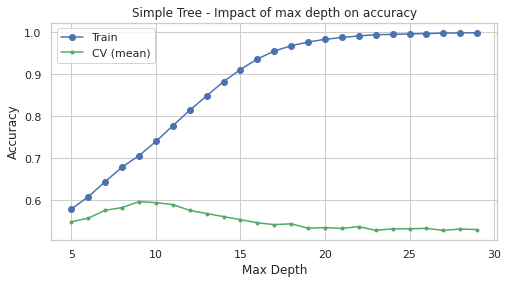

In [22]:
# Plot the accuracy
plt.figure(figsize=(8,4))
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.title('Simple Tree - Impact of max depth on accuracy')
plt.plot(depths, train_scores, 'b-', marker='o', label="Train")
plt.plot(depths, cvmeans, 'g-', marker='.', label="CV (mean)")

plt.legend()

plt.show()

Find best model based on CV score

In [23]:
dt_max_cv_acc = max(cvmeans)
dt_max_cv_index = cvmeans.index(dt_max_cv_acc)
dt_best_depth = depths[dt_max_cv_index]

print(f"Best CV score is {dt_max_cv_acc:0.4f} with max_depth of {dt_best_depth}")

Best CV score is 0.5971 with max_depth of 9


In [24]:
dt_model = DecisionTreeClassifier(max_depth=dt_best_depth).fit(X_train, y_train)

dt_y_pred_train = dt_model.predict(X_train)
dt_y_pred_test = dt_model.predict(X_test)

dt_train_score = accuracy_score(y_train, dt_y_pred_train)
dt_test_score = accuracy_score(y_test, dt_y_pred_test)

print(f"Simple DecisionTree Accuracy: depth={dt_best_depth}, TrainAcc={dt_train_score:0.4f}, TestAcc={dt_test_score:0.4f}")


Simple DecisionTree Accuracy: depth=9, TrainAcc=0.7066, TestAcc=0.6304


RandomForest - Find a max depth starting from the DecisionTreeClassifier's best max_depth

In [25]:
acc_train_scores = []
acc_val_scores =[]

depths = list(range(dt_best_depth, 30))

for d in tqdm(depths):
    rf_model = RandomForestClassifier(random_state=42, max_depth=d, max_features="sqrt")
    rf_model.fit(X_train, y_train)
    acc_train_scores.append( rf_model.score(X_train, y_train))
    
    cv_scores = cross_validate(rf_model, X_train, y_train, cv=5, return_estimator=True)
    cv_score = cv_scores['test_score'].mean()
    acc_val_scores.append(cv_score)
    

100%|██████████| 21/21 [04:40<00:00, 13.35s/it]


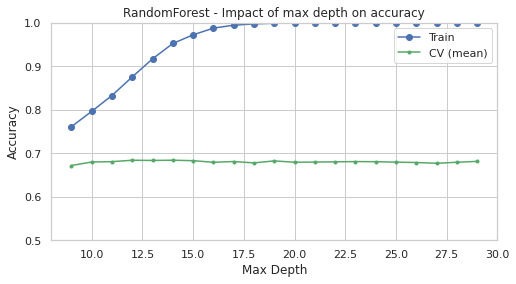

In [26]:
# Plot the accuracy
plt.figure(figsize=(8,4))
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.ylim(bottom=0.5)
plt.title('RandomForest - Impact of max depth on accuracy')
plt.plot(depths, acc_train_scores, 'b-', marker='o', label="Train")
plt.plot(depths, acc_val_scores, 'g-', marker='.', label="CV (mean)")

plt.legend()

plt.show()

In [27]:
rf_max_cv_acc = max(acc_val_scores)
rf_max_cv_index = acc_val_scores.index(rf_max_cv_acc)
rf_best_depth = depths[rf_max_cv_index]

print(f"Best RandomForest CV score is {rf_max_cv_acc:0.4f} with max_depth of {rf_best_depth}")    


Best RandomForest CV score is 0.6842 with max_depth of 14


RandomForest - find best number of estimators

In [28]:
print("Using max_depth = ", rf_best_depth)

min_estimators = 50
max_estimators = 250
step = 5

n_estimators = list(range(min_estimators, max_estimators + 1, step))

print(f"Using max_depth={rf_best_depth}, estimator range=[{min_estimators}, {max_estimators}]")

acc_train_scores = []
acc_val_scores =[]

for i in tqdm(n_estimators):
    rf_model = RandomForestClassifier(n_estimators=i, random_state=42, max_depth=rf_best_depth, max_features="sqrt")
    rf_model.fit(X_train, y_train)
    acc_train_scores.append( rf_model.score(X_train, y_train))
    
    cv_scores = cross_validate(rf_model, X_train, y_train, cv=5, return_estimator=True)
    cv_score = cv_scores['test_score'].mean()
    acc_val_scores.append(cv_score)
    

  0%|          | 0/41 [00:00<?, ?it/s]

Using max_depth =  14
Using max_depth=14, estimator range=[50, 250]


100%|██████████| 41/41 [12:30<00:00, 18.29s/it]


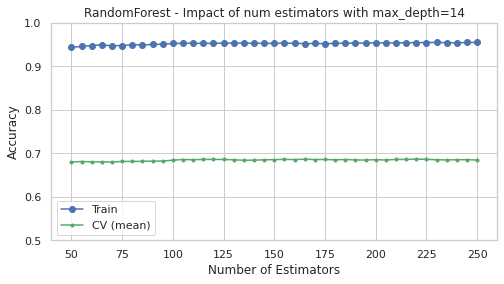

In [29]:
# Plot the accuracy
plt.figure(figsize=(8,4))
plt.ylabel("Accuracy")
plt.xlabel("Number of Estimators")
plt.ylim(bottom=0.5)
plt.title(f"RandomForest - Impact of num estimators with max_depth={rf_best_depth}")
plt.plot(n_estimators, acc_train_scores, 'b-', marker='o', label="Train")
plt.plot(n_estimators, acc_val_scores, 'g-', marker='.', label="CV (mean)")

plt.legend()

plt.show()

In [30]:
rf_max_cv_acc = max(acc_val_scores)
rf_max_cv_index = acc_val_scores.index(rf_max_cv_acc)
rf_best_num_estimators = n_estimators[rf_max_cv_index]

print(f"Best RandomForest CV score is {rf_max_cv_acc:.4f} at index={rf_max_cv_index} with n_estimators={rf_best_num_estimators}, best_max_depth={rf_best_depth}")


Best RandomForest CV score is 0.6866 at index=34 with n_estimators=220, best_max_depth=14


Create RandomForest model using best depth and estimator values

In [31]:
print(f"Using n_estimators={rf_best_num_estimators}, best_max_depth={rf_best_depth}")

best_rf_model = RandomForestClassifier(n_estimators=rf_best_num_estimators, max_depth=rf_best_depth, max_features="sqrt")
best_rf_model.fit(X_train, y_train)

rf_y_pred_train = best_rf_model.predict(X_train)
rf_y_pred_test = best_rf_model.predict(X_test)

rf_train_score = accuracy_score(y_train, rf_y_pred_train)
rf_test_score = accuracy_score(y_test, rf_y_pred_test)

print(f"RandomForest Accuracy: Train Set: {rf_train_score:0.4f}")
print(f"RandomForest Accuracy: Test Set: {rf_test_score:0.4f}")

Using n_estimators=220, best_max_depth=14
RandomForest Accuracy: Train Set: 0.9525
RandomForest Accuracy: Test Set: 0.6957


#### Feature Importance

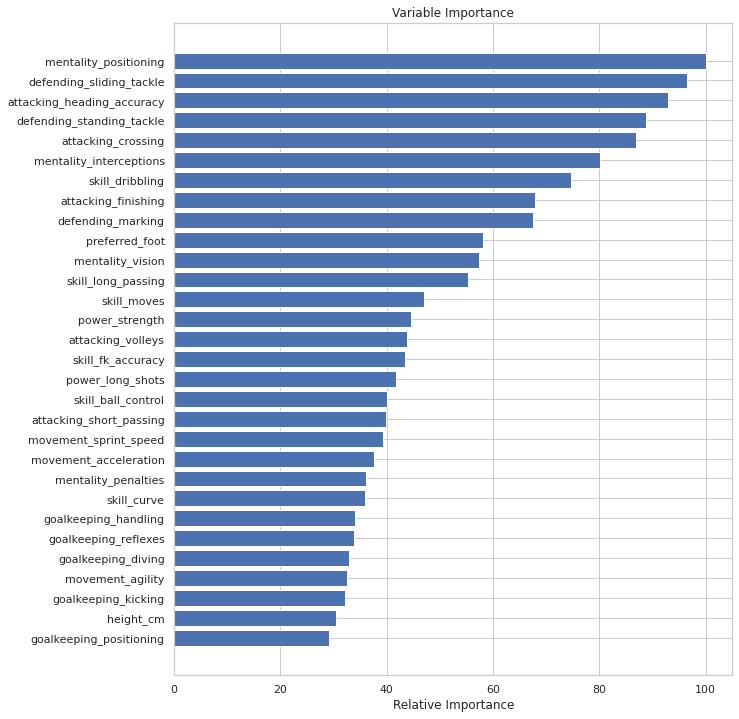

In [32]:
n_top = 30

#Top Features
feature_importance = best_rf_model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
top_idx = sorted_idx[-n_top:]

pos = np.arange(top_idx.shape[0]) + .5

#Plot
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[top_idx], align='center')
plt.yticks(pos, train_dataset.columns[top_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [33]:
for i, c in enumerate(train_dataset.columns):
    print(i, c)

0 age
1 height_cm
2 weight_kg
3 overall
4 potential
5 preferred_foot
6 weak_foot
7 skill_moves
8 work_rate
9 body_type
10 attacking_crossing
11 attacking_finishing
12 attacking_heading_accuracy
13 attacking_short_passing
14 attacking_volleys
15 skill_dribbling
16 skill_curve
17 skill_fk_accuracy
18 skill_long_passing
19 skill_ball_control
20 movement_acceleration
21 movement_sprint_speed
22 movement_agility
23 movement_reactions
24 movement_balance
25 power_shot_power
26 power_jumping
27 power_stamina
28 power_strength
29 power_long_shots
30 mentality_aggression
31 mentality_interceptions
32 mentality_positioning
33 mentality_vision
34 mentality_penalties
35 mentality_composure
36 defending_marking
37 defending_standing_tackle
38 defending_sliding_tackle
39 goalkeeping_diving
40 goalkeeping_handling
41 goalkeeping_kicking
42 goalkeeping_positioning
43 goalkeeping_reflexes
44 player_best_position
45 trait_1-on-1_rush
46 trait_avoids_using_weaker_foot
47 trait_backs_into_player
48 trait_